# I. Algorithm 


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import imageio
from IPython.display import Image

In [80]:
class Perceptron(object):
    weights = None
    bias = None

    def activate(self, preactivation):
        '''
        Returns the sign of the preactivation value.
        '''
        return 2 * (preactivation > 0) - 1
    

    def predict(self, signal):
        '''
        Taking linear combination of signal and weights and adding bias to get preactivation value
        '''
        preactivation = np.matmul(signal, self.weights) + self.bias
        return self.activate(preactivation)
    
    def update(self, actual, predicted, signal):
        '''
        Updates the weights of Perceptron
        '''
        self.weights = self.weights - 1/2 * (predicted - actual) * signal.T
        self.bias = self.bias - 1/2 * (predicted - actual)

    def cost_function(self, actual, predicted):
        '''
        Returns 1 if actual = predicted, 0 otherwise
        '''
        return(actual != predicted)
    def train(self, X, y, epochs=20, plot_interval = 10):
        '''
        Trains the perceptron over the given dataset (X, y) for a specified number of epochs.
        '''
        # Initialize weights and bias if not already set
        if self.weights is None:
            self.weights = np.zeros(X.shape[1])
        if self.bias is None:
            self.bias = 0
        
        epoch_error = np.zeros((epochs, ))

        for epoch in range(epochs):
            # Going through the training data
            for i in range(len(X)):
                signal = X[i]
                actual = y[i]
                predicted = self.predict(signal)
                # Updating weights
                if self.cost_function(actual, predicted):
                    self.update(actual, predicted, signal)
                    epoch_error[epoch] += 1
            if epoch % 20 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Misclassifications: {epoch_error[epoch]}")
            if epoch_error[epoch] <= len(X)/20: # Stop training when less than 5% error
                print("Training converged.")
                break
        
            # Create plot for decision boundaries
            if epoch % plot_interval == 0 or epoch == 1 or epoch == epochs:
                self.plot_decision_boundary(X, y, epoch)
        return epoch_error
    
    def plot_decision_boundary(self, X, y, epoch):
        '''
        Plotting decision boundary and saving a file
        '''
        plot_decision_regions(X=X, y=y, clf=self, legend=2)
        plt.title(f'Decision Boundary at Epoch {epoch}')
        plt.xlabel('Rating Average')
        plt.ylabel('Complexity')
    
        # Save the plot to file
        plt.savefig(f'decision_boundary_epoch_{epoch}.png')
        plt.close()  # Close the plot so it doesn't keep stacking in memory

# II. Application to Data Set

Let's first load in our data set and look at it briefly. We plan on using Rating Average and Complexity Average to classify our board games.

In [1]:
game_data = pd.read_csv("../bgg_dataset.csv",delimiter=";")
game_data.info()

NameError: name 'pd' is not defined

In [53]:
game_data.head(6)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
5,291457.0,Gloomhaven: Jaws of the Lion,2020.0,1,4,120,14,8392,"8,87",6,"3,55",21609.0,"Action Queue, Campaign / Battle Card Driven, C...","Strategy Games, Thematic Games"


: 

As you can see, the Rating Average and Complexity Average columns have commas instead of decimal points. We need to clean this.

In [54]:
game_data['Complexity Average'] = game_data['Complexity Average'].str.replace(',', '.').astype(float)
game_data['Rating Average'] = game_data['Rating Average'].str.replace(',', '.').astype(float)

: 

In [55]:
# Selecting Columns of Top 100 Games
game_cleaned = game_data[['Rating Average','Complexity Average','Min Age','Play Time','Min Players','BGG Rank','Domains']]
game_cleaned = game_cleaned[game_cleaned['BGG Rank'] <= 100]
game_cleaned.dropna(inplace = True)

# Labelling short games as those where play time is less than or equal to 60 minutes
game_cleaned['short'] = np.where(game_cleaned['Play Time'] <= 60, 1, -1)

short = game_cleaned[game_cleaned['short'] == 1]
long = game_cleaned[game_cleaned['short'] == -1]


: 

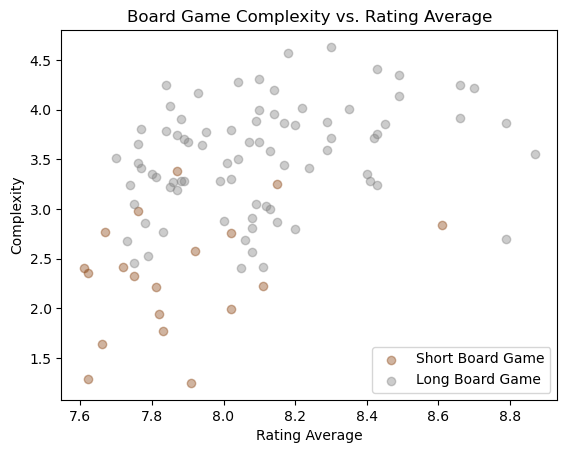

: 

In [56]:
# Plot short board games
plt.scatter(short['Rating Average'], short['Complexity Average'], color='saddlebrown', label='Short Board Game', alpha=0.4)

# Plot long board games
plt.scatter(long['Rating Average'], long['Complexity Average'], 
            color='gray', label='Long Board Game', alpha=0.4)

# Labels and title
plt.xlabel('Rating Average')
plt.ylabel('Complexity')
plt.title('Board Game Complexity vs. Rating Average')
# Add legend
plt.legend()
# Show plot
plt.show()

We can see some type of relationship where short board games tend to have lower complexity and lower rating averages. We will attempt to use our perceptron to come up with a board game classifier that captures this trend.

In [81]:
X_train = game_cleaned[['Rating Average','Complexity Average']].to_numpy()
y_train = game_cleaned['short'].to_numpy()

p = Perceptron()
errors = p.train(X_train,y_train, epochs = 400)

Epoch 1/400, Misclassifications: 27.0


/Users/jonathancheng/opt/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:315: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


Epoch 21/400, Misclassifications: 16.0
Epoch 41/400, Misclassifications: 14.0
Epoch 61/400, Misclassifications: 14.0
Epoch 81/400, Misclassifications: 15.0
Epoch 101/400, Misclassifications: 14.0
Epoch 121/400, Misclassifications: 10.0
Epoch 141/400, Misclassifications: 12.0
Epoch 161/400, Misclassifications: 12.0
Epoch 181/400, Misclassifications: 10.0
Epoch 201/400, Misclassifications: 18.0
Epoch 221/400, Misclassifications: 14.0
Epoch 241/400, Misclassifications: 12.0
Epoch 261/400, Misclassifications: 14.0
Epoch 281/400, Misclassifications: 16.0
Epoch 301/400, Misclassifications: 12.0
Epoch 321/400, Misclassifications: 14.0
Epoch 341/400, Misclassifications: 12.0
Epoch 361/400, Misclassifications: 14.0
Epoch 381/400, Misclassifications: 14.0


: 

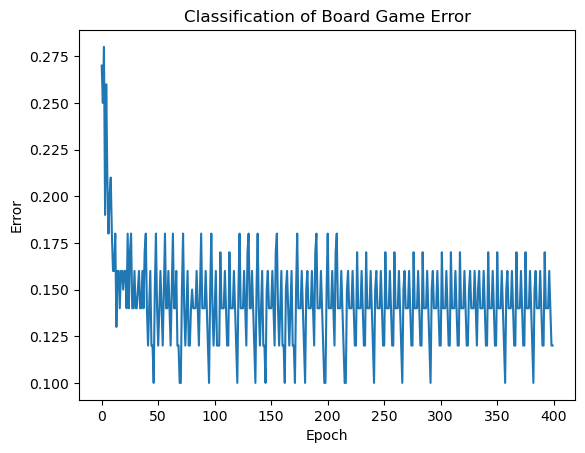

: 

In [72]:
plt.plot([err / 100 for err in errors])
plt.title("Classification of Board Game Error")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

In [73]:
print(f"The final classification accuracy is {100-errors[len(errors)-1]}%.")

The final classification accuracy is 88.0%.


: 

Now, let's use plot_decision_regions to visualize our perceptron model.

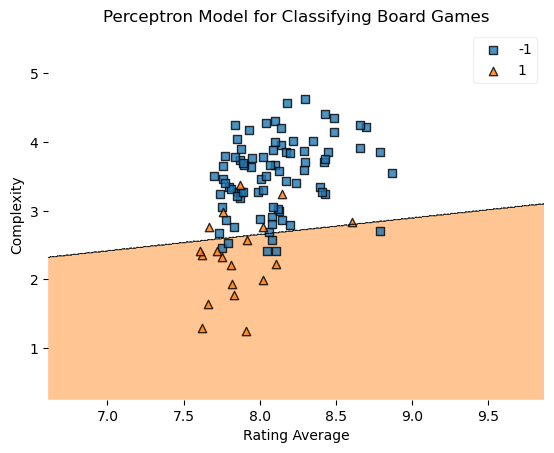

: 

In [76]:
#plot_decision_regions(X=X_train, y=y_train, clf=p, legend=2)

plot_decision_regions(X_train, y_train, clf=p)
plt.xlabel('Rating Average')
plt.ylabel('Complexity')
plt.title('Perceptron Model for Classifying Board Games')
plt.show()

In [42]:
print(f'The equation of the dividing line is y = {round(-1/p.weights[1]*p.weights[0],2)}x+{round(-1*p.bias/p.weights[1],2)}.')

The equation of the dividing line is y = 0.24x+0.74.


: 

Now, let's visualize how the perceptron's dividing line changes as we train our model for various epochs. Note that in GitHub this gif may not display properly, so you can look at ```training_evolution.gif``` in the folder.

/var/folders/xh/x976_5p93059y1sn4ybh8ql40000gn/T/ipykernel_99535/488727058.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


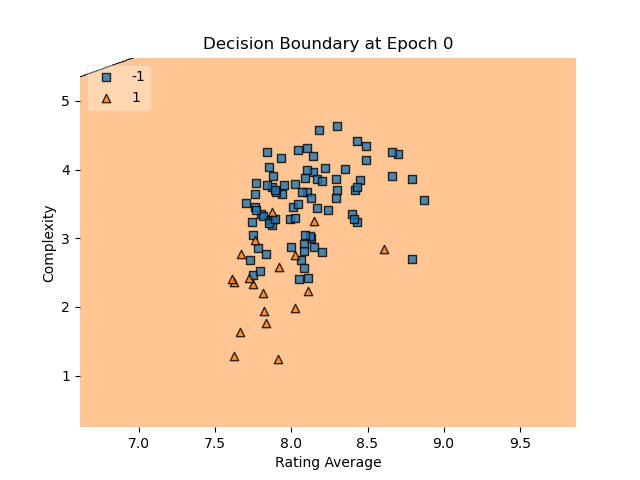

: 

In [87]:
images = []
for epoch in range(0, 400, 10):
    filename = f"decision_boundary_epoch_{epoch}.png"
    images.append(imageio.imread(filename))
imageio.mimsave("training_evolution.gif", images, fps=2)

Image(filename="training_evolution.gif")

As you can see our dividing line never converges but instead fluctuates up and down. We can also see this with the classification error as it also oscillates between 12 and 14%. This flaw in the perceptron model comes from the fact that our data is not **linearly separatable**. Thus, we can see the limitations of the perceptron model in classification.